# Background



Technology has democratized advertising in our society, with influencer marketing emerging as a mainstream form of online marketing. Brands collaborate with popular online influencers to market products or services in order to improve brand recognition among target audiences. Unlike celebrities, influencers in social media can be anyone who has built a reputation for their knowledge and expertise on a specific topic. They are influential due to their large followings on the web which brands take advantage of because they can create trends and encourage their followers to buy products they promote. Influencers have the potential to affect the purchasing decisions of others because of their authority, knowledge, position, or relationship with their audience. 

Despite the results that can be gained through influencer marketing, researching and finding the right influencers is not an easy process. To achieve results and effectively engage the right audience, brands need to identify individuals who can act as genuine brand ambassadors and bring consumers on board with the products and services. Selecting an influencer that fits the brand can help to achieve the engagement and traffic desired. Simply looking at online profiles with the most followers might not satisfy a particular niche for the brands which is why they often spend considerable time finding the right influencers to achieve a good engagement rate with a targeted audience. Determining how different influencers generate traction and engagement rate is important, so that brands can allocate their budget more effectively when looking to sponsor. Thus, the main objective for this project is to examine how information on Instagram posts (captions, comments, sponsorship) and the influencer (category, bio, followers, followees) can be used to determine how popular a post will be. In particular, I also believe that the content of captions accompanying Instagram posts provide important context and are thus important in eliciting likes and shares.


# Dataset Source

The data we are using is collected from Instagram by Seungbae Kim, an assistant professor at University of South Florida for research purposes and was obtained with his consent (Kim et al., 2021):
https://sites.google.com/site/sbkimcv/dataset

This dataset contains information about influencer posts that have association with different brands. There are approximately 1.6 million Instagram posts, 26,910 brand names, and 38,113 different unique influencers in our dataset (Kim et al., 2021). The posts are specifically split into two types of categories: sponsored brand mentions and non-sponsored brand mentions. A sponsored post is one where the influencer gets paid for advertising and mentioning the name of the brand. 

# Text Preprocessing

The original raw data files given to us by Professor Kim comprise multiple JSON and text files. Due to the size of the data, we had to manually extract the information from each file in order to clean, process and merge it all into one big dataset for analysis.

There are approximately 12 GB (3 GB when in zipped format) worth of JSON files containing specific profile and post information. The 1,601,074 JSON files are structured such that each file contains information on 1 profile. Since the number of fields available in each JSON file is not consistent, we extracted relevant fields from the approximately 1.6 million files and compiled them into a single dataset. During this process of compiling the JSON files, we also unpacked the objects within the JSON files and cleaned the dataset. 

For instance, the captions and comments were packed into dictionaries and required unpacking. Notably, the text in the captions or comments were not analyzed in the original paper by the author (Kim et al., 2021). However, the nature of the content can possibly add a useful dimension to the dataset. Thus, we decided to take up the challenge of doing NLP processing of this huge Instagram dataset.

Because we were interested in predicting popular influencers and not the content of comments elicited and also because of the constraint of resources and time, we decided to use only the captions as a feature to predict popularity. Caption content is relevant because it adds to the information of a post’s picture and can elicit strong responses, sharing by viewers and lend context to the post. In addition, only a subset of the JSON posts had comments, thus we decided to focus on the captions.


In [344]:
# import necessary libraries
import nltk
from nltk.corpus import stopwords
import os
import string
import pandas as pd
import numpy as np
import zipfile
import io
import re
from textblob import Word
import math
import json
#from textblob import TextBlob
#from langdetect import detect
import matplotlib.pyplot as plt
import langid
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from nltk.stem import *
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.ensemble import AdaBoostRegressor

In [345]:
#download stopwords for text analysis later on
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chouche7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chouche7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/chouche7/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/chouche7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Functions for cleaning text

In [346]:
# create function for punctuation removal:
def remove_punctuations(text):
    for char in string.punctuation:
        text = text.replace(char, '')
    return text

# create function for contraction removal:
def contractions(s):
    s = re.sub(r"won’t", "will not",s)
    s = re.sub(r"would’t", "would not",s)
    s = re.sub(r"could’t", "could not",s)
    s = re.sub(r"\’d", " would",s)
    s = re.sub(r"can\’t", "can not",s)
    s = re.sub(r"n\’t", " not", s)
    s = re.sub(r"\’re", " are", s)
    s = re.sub(r"\’s", " is", s)
    s = re.sub(r"\’ll", " will", s)
    s = re.sub(r"\’t", " not", s)
    s = re.sub(r"\’ve", " have", s)
    s = re.sub(r"\’m", " am", s)
    return s

### Load influencer profile data from multiple sources

In [347]:
#read our data on instagram posts
with open('project_data/post_info.txt') as f:
    lines = f.readlines()

In [348]:
data  = [x.split("\t") for x in lines]

post_df = pd.DataFrame(data, columns = ["post_id", "username", "sponsored", "json_id", "jpg_file"])
post_df = post_df[["post_id", "username", "sponsored", "json_id"]]

post_df["json_id"] = post_df["json_id"].replace(r'.json','', regex=True) 
post_df.head()

,post_id,username,sponsored,json_id
0,0,alisasia,1,1309041812857818435
1,1,alisasia,0,1311846669234786866
2,2,alisasia,0,1315560311952470229
3,3,alisasia,0,1318531733175899446
4,4,alisasia,0,1343280729400051114


In [349]:
#read our data on influencers in a zip file
myzipfile= zipfile.ZipFile('project_data/profiles_influencers.zip')
influ_files = myzipfile.namelist()[1:]

In [350]:
profile_df = []
with zipfile.ZipFile('project_data/profiles_influencers.zip', 'r') as zip:
    for file in influ_files:
        username = file.split("/")[1]
        data = zip.read(file)
        data = io.StringIO(data.decode())
        data  = [x.split("\t") for x in data]
        data = [col for sublist in data for col in sublist if col != "\n"]
        data.insert(0, username)
        profile_df.append(pd.DataFrame([data], columns = ["username", "name", "followers", "followees", "posts", "url", "t/f", "category", "bio", "email", "phone", "profile_pic"]))

profile_df = pd.concat(profile_df, ignore_index = True)
profile_df = profile_df[["username", "name", "followers", "followees", "posts", "url", "category", "bio"]]
profile_df.head()

,username,name,followers,followees,posts,url,category,bio
0,fodmap_friendly_eating,FODMAP Friendly Eating,11299,2609,549,https://fodmapfriendlyeating.wordpress.com/,Creators & Celebrities,Delicious FODMAP Friendly recipes from @antoni...
1,paileaa,paige leanne,12615,1207,1386,https://paileaa.com/2018/10/08/that-last-bit-o...,Creators & Celebrities,London | positive vibes & good times p.goodes...
2,a12team,A12 Team,1319,861,405,http://www.a12.com.pl/,Food & Personal Goods,Photography & Production services 📩 info@a12....
3,ilbulgaro89,Andrea Paesetti,1547,909,1250,http://youtube.com/c/SpazioiTechItalia,Creators & Celebrities,Italian -- #Technology addicted -- Editor & Re...
4,joililikoi,Joie Lee Ruggiero,7427,1836,908,http://wearehaumea.com/retreats,NULL,HI / LA | I seek to inspire and be inspired ...


In [351]:
#merge data on post and influencer into one
posts_influ_df = pd.merge(post_df, profile_df, on="username")

#drop unnecessary columns that won't be used in the model
posts_influ_df = posts_influ_df.filter(items=['sponsored', 'json_id', 'followers', "followees", 'category'])
posts_influ_df.drop_duplicates(subset=['json_id'], inplace = True)
posts_influ_df['json_id']=posts_influ_df['json_id'].astype(int)
posts_influ_df.head()

,sponsored,json_id,followers,followees,category
0,1,1309041812857818435,41099,320,Creators & Celebrities
1,0,1311846669234786866,41099,320,Creators & Celebrities
2,0,1315560311952470229,41099,320,Creators & Celebrities
3,0,1318531733175899446,41099,320,Creators & Celebrities
4,0,1343280729400051114,41099,320,Creators & Celebrities


In [352]:
# define data
posts_influ_df = posts_influ_df.loc[posts_influ_df["category"] != "NULL"]
categorical = posts_influ_df[["category"]]
for col in categorical:    
    # define one hot encoding
    encoder = OneHotEncoder(sparse=False)
    # transform data
    cat = np.array(categorical[col]).reshape(-1, 1)
    onehot = encoder.fit_transform(cat)
    onehot = pd.DataFrame(onehot)
    onehot.columns = col + "_" + encoder.get_feature_names_out()
    onehot.columns = [x.replace(r'_x0','') for x in onehot.columns]
    posts_influ_df = pd.concat([posts_influ_df, onehot], axis=1, join='inner')
    posts_influ_df = posts_influ_df.loc[:, posts_influ_df.columns != col]
posts_influ_df.head()

,sponsored,json_id,followers,followees,category_Auto Dealers,category_Business & Utility Services,category_Content & Apps,category_Creators & Celebrities,category_Entities,category_Food & Personal Goods,...,category_Home Goods Stores,category_Home Services,category_Lifestyle Services,category_Local Events,category_Non-Profits & Religious Organizations,category_Personal Goods & General Merchandise Stores,category_Professional Services,category_Publishers,category_Restaurants,category_Transportation & Accomodation Services
0,1,1309041812857818435,41099,320,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1311846669234786866,41099,320,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1315560311952470229,41099,320,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1318531733175899446,41099,320,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1343280729400051114,41099,320,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load information about posts

In [353]:
first = pd.read_csv("project_data/compiled_jsons_0_400000_trimmed.csv")
second = pd.read_csv("project_data/compiled_jsons_400000_800000_trimmed.csv")
third = pd.read_csv("project_data/compiled_jsons_800000_1200000_trimmed.csv")
fourth = pd.read_csv("project_data/compiled_jsons_1200001_1601074_trimmed.csv")
first.head()

/var/folders/b3/2c5nrf8s3k3f2z_yxv6vpz340000gn/T/ipykernel_64776/1567730900.py:1: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  first = pd.read_csv("project_data/compiled_jsons_0_400000_trimmed.csv")
/var/folders/b3/2c5nrf8s3k3f2z_yxv6vpz340000gn/T/ipykernel_64776/1567730900.py:4: DtypeWarning: Columns (22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  fourth = pd.read_csv("project_data/compiled_jsons_1200001_1601074_trimmed.csv")


,Unnamed: 0,id,is_video,taken_at_timestamp,edge_media_preview_like_count,edge_media_to_caption_edges,edge_media_to_comment_count,owner_id,is_ad,viewer_can_reshare,...,viewer_has_saved_to_collection,viewer_in_photo_of_you,edge_media_preview_like_edges,edge_media_to_comment_edges,edge_media_to_comment_page_info_end_cursor,edge_media_to_comment_page_info_has_next_page,edge_media_to_sponsor_user_edges,edge_media_to_tagged_user_edges,edge_web_media_to_related_media_edges,owner_username
0,0,1000013365102810365,False,1433430904,3390,"[{'node': {'text': '#Regram from @lucavezil: ""...",26,222106572,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1000043359370989848,False,1433434480,125,[{'node': {'text': 'Our society today is so de...,5,237634851,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1000055615134224232,False,1433435941,22652,[{'node': {'text': 'brought out my cute lil @b...,62,19538442,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1000084729422320243,False,1433439411,272,[{'node': {'text': 'How about Sweet Potato Pea...,28,1431250163,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1000147795992383306,False,1433446929,7407,"[{'node': {'text': ""In the end, we only regret...",33,258280258,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [354]:
first = first[["id", "edge_media_preview_like_count", "edge_media_to_caption_edges"]]
second = second[["id", "edge_media_preview_like_count", "edge_media_to_caption_edges"]]
third = third[["id", "edge_media_preview_like_count", "edge_media_to_caption_edges"]]
fourth = fourth[["id", "edge_media_preview_like_count", "edge_media_to_caption_edges"]]

df1 = pd.concat([first, second, third, fourth], axis = 0)
df1["edge_media_to_caption_edges"] = [cap.split("text':")[1] if cap != '[]' else "" for cap in df1["edge_media_to_caption_edges"]]
df1 = df1.rename(columns={"id": "json_id", "edge_media_preview_like_count": "likes_per_follower", 
                              "edge_media_to_caption_edges": "caption"})

In [355]:
# dataset is too big and long to run, so we are going to sample 10% of it at random
df1_sampled = df1.sample(math.floor(df1.shape[0] * 0.1), random_state = 0)
df1_sampled.drop_duplicates(subset=['json_id'], inplace = True)
df1_sampled.shape

(160107, 3)

In [356]:
df1_sampled

,json_id,likes_per_follower,caption
14849,1845819969957040871,2861,'#ad Of course the first week that my new whi...
326085,1700130069736603012,2353,'The guest room is looking like a modge podge...
221727,1888646704637258222,1466,'Weekend mode 🤘🏽 @nblifestyle #x90'}}]
323065,1698719781907498047,211,'Ragazze vi ricordo di nuovo della promozione...
69096,1857639984522215438,444,'#ad If you’ve met me you know I am a pizza o...
...,...,...,...
208579,1629315589330543564,306,'Alguém aí me dá um espelhão de presente!? 😅 ...
315582,1694622502637852288,5133,'When road tripping in brazil 🖖🏼 @movidaalugu...
383701,2023658532024824986,1282,"'My basics this season! Clear bag, pearl hai..."
312219,1907261909552837402,1067,"""I'm loving the NEW Tic Tac Gum! The all-new ..."


In [357]:
df1_sampled = df1_sampled.loc[df1_sampled["caption"].isnull() != True ]
df1_sampled = df1_sampled.loc[df1_sampled["caption"] != None]

### Clean captions (stemming, lemmatization, stop words removal) for NLP analysis using TF-IDF


Bag-of-words model was used as a tool of feature generation for the captions. After transforming the text of captions into a bag-of-words, we performed the calculation of term frequency, which refers to the number of times a term appears in the text. Term frequency (TF) might not be the best representation of the text because the common words like ‘the’,’a’,’is’ are most likely to be the highest frequency terms. Thus, to address this problem, the term frequency was converted into term frequency-inverse document frequency (TF-IDF). The reason we need IDF is to minimize the weighting of common terms while making infrequent terms have a higher impact. Putting both together, the TF-IDF score tells how important and relevant a term is. 

Then, we performed sentiment analysis on the text of comments to tag the comments as “positive”, “neutral” and “negative”. This will add a useful feature of popularity in addition to the number of likes and comments a post garners. While we initially planned to create our own sentiment analysis model using the TF-IDF results and compare with some pre-trained models, the sheer volume of the data meant that we were unable to complete some steps because of the limitations of our systems’ computing power. 


In [358]:
#clean the captions by removing punctuations, lower casing, and removing stop words
df1_sampled["caption"] = df1_sampled["caption"].str.lower()
df1_sampled["caption"] = df1_sampled["caption"].apply(lambda x: re.sub(r'@\w+', "", x))
df1_sampled["caption"] = df1_sampled["caption"].apply(remove_punctuations)

stop = stopwords.words('english')
df1_sampled["caption"] = df1_sampled["caption"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
#df1["caption"] = df1["caption"].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

In [359]:

df1_sampled["caption"]=df1_sampled["caption"].apply(lambda x:contractions(x))
df1_sampled["caption"]=df1_sampled["caption"].apply(lambda x: re.sub(' +', ' ', x))


In [360]:
#utilize the textblob package to edit wrong words
#df1["caption"] = df1["caption"].apply(lambda x: TextBlob(x).correct())

In [361]:
df1_sampled = df1_sampled.loc[df1_sampled["caption"].isnull() != True ]
df1_sampled = df1_sampled.loc[df1_sampled["caption"] != None]

In [362]:
#keep only the stem of every word
lemmatizer = WordNetLemmatizer()
df1_sampled["caption"] = df1_sampled["caption"].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df1_sampled["caption"].head()

14849     ad course first week new white outdoor furnitu...
326085    guest room looking like modge podge it is walk...
221727                                  weekend mode 🤘🏽 x90
323065    ragazze vi ricordo di nuovo della promozione s...
69096     ad you have met know pizza obsessed girl 🍕🍕🍕 r...
Name: caption, dtype: object

In [363]:
#remove non english words
words = set(nltk.corpus.words.words())

df1_sampled["caption"] = df1_sampled["caption"].apply(lambda x: " ".join([word for word in x.split() \
         if word in words]))

#df1["caption"] = df1["caption"].apply(lambda x: " ".join(x.split()))
    
df1_sampled["caption"].head()

14849     ad course first week new white outdoor furnitu...
326085    guest room looking like podge it is walkable y...
221727                                         weekend mode
323065    di di di la neon che di e sulla e link story n...
69096     ad you have met know pizza girl really really ...
Name: caption, dtype: object

In [364]:
# analyze what language each caption is
df1_sampled["lang"] = df1_sampled["caption"].apply(lambda x: langid.classify(x)[0])


In [365]:
#remove captions that aren't english
df1_sampled = df1_sampled.loc[df1_sampled["lang"] == "en"]
df1_sampled.head()

,json_id,likes_per_follower,caption,lang
14849,1845819969957040871,2861,ad course first week new white outdoor furnitu...,en
326085,1700130069736603012,2353,guest room looking like podge it is walkable y...,en
69096,1857639984522215438,444,ad you have met know pizza girl really really ...,en
67335,1755629379831914897,926,messy house busy schedule two event next four ...,en
18884,1846626533457043079,440,what is harder hold hot potato wet baby shower...,en


In [366]:
# TF-IDF

#Convert a collection of text documents to a matrix of token counts (for each word)
tfidfconverter = TfidfVectorizer(max_features = 500, min_df= 100, max_df=0.7, stop_words=stopwords.words('english'))  
tf_idf_vector = tfidfconverter.fit_transform(df1_sampled["caption"]).toarray()
feature_names = tfidfconverter.get_feature_names_out()

print(tf_idf_vector.shape)
#show an example of the first document tf_idf breakdown
first_document_vector=tf_idf_vector[1]
df_tfifd= pd.DataFrame(first_document_vector, index=feature_names, columns=["tfidf"])
df_tfifd.sort_values(by=["tfidf"],ascending=False)


(126911, 500)


,tfidf
save,0.536792
looking,0.472099
like,0.311254
room,0.269867
water,0.261647
...,...
flavor,0.000000
fitness,0.000000
fit,0.000000
first,0.000000


In [367]:
#tf_idf = TfidfVectorizer()
#word_vectors = tf_idf.fit_transform(df1_sampled["caption"])
df1_sampled.reset_index(drop=True, inplace=True)
word_vectors = pd.DataFrame(tf_idf_vector, columns = feature_names)
df1_sampled = pd.concat([df1_sampled[["json_id", "likes_per_follower"]]
                        , word_vectors], axis=1)

In [368]:
df1_sampled = df1_sampled.merge(posts_influ_df, how ='inner', on = "json_id")

In [369]:
df1_sampled.shape

(99781, 526)

In [370]:
#final_data = final_data.merge(likes, how = "left", on= "json_id")
df1_sampled["followers"] = df1_sampled["followers"].astype(int)
df1_sampled["likes_per_follower"] = df1_sampled["likes_per_follower"]/df1_sampled["followers"]
df1_sampled.head()

,json_id,likes_per_follower,able,absolutely,actually,ad,add,added,adventure,ago,...,category_Home Goods Stores,category_Home Services,category_Lifestyle Services,category_Local Events,category_Non-Profits & Religious Organizations,category_Personal Goods & General Merchandise Stores,category_Professional Services,category_Publishers,category_Restaurants,category_Transportation & Accomodation Services
0,1845819969957040871,0.009462,0.0,0.0,0.0,0.143341,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1700130069736603012,0.046147,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1755629379831914897,0.018495,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1846626533457043079,0.040249,0.0,0.0,0.0,0.168138,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1517839551120552138,0.008871,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


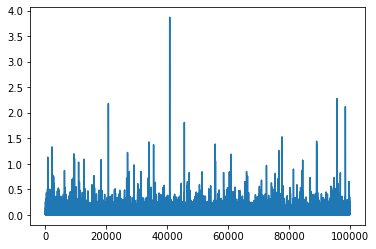

In [371]:
plt.plot(df1_sampled["likes_per_follower"])

In [372]:
final_data = df1_sampled.drop(["json_id","followers", "followees"], axis = 1)

In [373]:
np.mean(final_data["likes_per_follower"])

0.041920480935993765

In [374]:
np.std(final_data["likes_per_follower"])

0.05055948069767976

# Model Building

### Linear Regression

In [375]:
X = final_data.loc[:, final_data.columns != "likes_per_follower"]
Y = final_data["likes_per_follower"]

indices = np.arange(X.shape[0])
X_train, X_test, Y_train, Y_test, X_index, Y_index = train_test_split(X, Y, indices, test_size = .30, random_state = 0)

cv = KFold(n_splits=5, random_state=0, shuffle=True)

reg = LinearRegression().fit(X_train, Y_train)
reg.score(X_train, Y_train)

0.024381076558064763

In [376]:
y_pred=reg.predict(X_train)

In [377]:
rmse = math.sqrt(mean_squared_error(Y_train, y_pred))
print("Training RMSE of the model is %.4f" %rmse)

Training RMSE of the model is 0.0492


In [378]:
scores = cross_val_score(reg, X_train, Y_train, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)

print("Validation RMSE of the model is %.4f" %np.mean(np.absolute(scores)))

Validation RMSE of the model is 8572317.3908


In [379]:
#add constant to predictor variables
x = sm.add_constant(X_train)

#fit linear regression model
model = sm.OLS(np.asarray(Y_train, dtype=float), np.asarray(x, dtype=float)).fit() 

#create instance of influence
influence = model.get_influence()

#obtain Cook's distance for each observation
cooks = influence.cooks_distance[0]

#display Cook's distances
print(cooks)

[1.72645645e-06 1.09976987e-08 6.01175884e-05 ... 2.49091237e-05
 1.25516442e-05 5.19787452e-06]


In [380]:
X_train_cooks = X_train.loc[cooks < (4/len(cooks))]
y_train_cooks = Y_train.loc[cooks < (4/len(cooks))]

In [381]:
reg = LinearRegression().fit(X_train_cooks, y_train_cooks)
reg.score(X_train_cooks, y_train_cooks)

0.04077430159028017

In [382]:
y_pred=reg.predict(X_train_cooks)

In [383]:
rmse = math.sqrt(mean_squared_error(y_train_cooks, y_pred))
print("Training RMSE of the model is %.4f" %rmse)

Training RMSE of the model is 0.0289


In [384]:
scores = cross_val_score(reg, X_train_cooks, y_train_cooks, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)

#view RMSE (validation error)
print("Validation RMSE of the model is %.4f" %np.mean(np.absolute(scores)))

Validation RMSE of the model is 0.0291


### LASSO

The LASSO penalization model is used because we have over 100 predictors (due to the TF-IDF creating new features for each word) and LASSO is known to penalize the model for unnecessary features which will help us narrow down the important factors. Not only does it control model complexity and variable selection, it also encourages sparsity in solution.


In [385]:
lasso = LassoCV(cv=5, random_state=0).fit(X_train_cooks, y_train_cooks)

/Users/chouche7/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012613991191251728, tolerance: 0.004793561289913987
  model = cd_fast.enet_coordinate_descent_gram(
/Users/chouche7/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006128265053746418, tolerance: 0.004742163291024567
  model = cd_fast.enet_coordinate_descent_gram(
/Users/chouche7/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034932879477864276, tolerance: 0.004742163291024567
  model = cd_fast.enet_coordinate_descent_gram(


In [386]:
lasso_features = lasso.feature_names_in_[lasso.coef_ != 0]

In [387]:
lasso_features.shape

(406,)

In [388]:
X = X_train_cooks.loc[:, X_train_cooks.columns.isin(lasso_features)]
#Y = final_data["likes_per_follower"]


#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .30, random_state = 0)
lasso = LinearRegression().fit(X, y_train_cooks)
lasso.score(X, y_train_cooks)

0.04054671711627744

In [389]:
y_pred=lasso.predict(X)

rmse = math.sqrt(mean_squared_error(y_train_cooks, y_pred))
print("Training RMSE of the model is %.4f" %rmse)

Training RMSE of the model is 0.0289


In [390]:
scores = cross_val_score(lasso, X, y_train_cooks, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)

print("Validation RMSE of the model is %.4f" %np.mean(np.absolute(scores)))

Validation RMSE of the model is 0.0291


### AdaBoost

The AdaBoost model builds on top of the previous models’ error in order to create one effective model. Boosting is generally better than bagging (random forest) when the classifier is stable and simple (high bias) whereas bagging is better when there is high variance (overfitting).

One thing to note is that boosting algorithms are extremely sensitive to outliers. This is because every classifier works off of the errors of its predecessors, so every model is forced to learn even the “bad” data. To prevent this from occurring, we made our best attempt in removing outliers by applying Cook’s Distance first to a multiple linear regression model. Cook’s Distance is measured by the difference in fitted values when the specific datum point is removed from the model; hence, data that shift our output values greatly will have a large distance (to be removed). Usually, this method only applies to the least-squares method, but due to time constraints, we used it to look for highly influential points for both the LASSO and AdaBoost models.

In [391]:
for depth in range (3,10):
    tree_classifier=tree.DecisionTreeRegressor(max_depth=depth,random_state=0)
    tree_classifier.fit(X, y_train_cooks)
    score=np.mean(np.absolute(cross_val_score(tree_classifier,X, y_train_cooks,scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)))
    print(depth, score)

3 0.02942968573976506
4 0.029424359561097662
5 0.02942964175005545
6 0.029452221622661874
7 0.029467597921085296
8 0.02949038964962264
9 0.029529334150927723


In [392]:
#HYPER-PARAMETER TUNING for number of trees and learning rate
#this takes a couple hours to run
#don't run this unless the data has changed

#ada=AdaBoostRegressor(base_estimator=tree.DecisionTreeRegressor(max_depth=3,random_state=0))
#search_grid={'n_estimators':[50,75,100,150],'learning_rate':[.01,0.1,1]}
#ada_clf=GridSearchCV(estimator=ada,param_grid=search_grid,scoring='neg_root_mean_squared_error', cv=cv, return_train_score = True)
#ada_clf.fit(X, y_train_cooks)
#ada_clf.best_params_

#best_param is 100, 0.01

In [394]:
ada_clf=AdaBoostRegressor(base_estimator=tree.DecisionTreeRegressor(max_depth=4,random_state=0), n_estimators = 100, learning_rate = 0.01, random_state=0)
ada_clf.fit(X, y_train_cooks)

y_pred=ada_clf.predict(X)

rmse = math.sqrt(mean_squared_error(y_train_cooks, y_pred))
print("Training RMSE of the model is %.4f" %rmse)

Training RMSE of the model is 0.0294


In [395]:
#print("Validation RMSE of the model is %.4f" %np.mean(np.absolute(ada_clf.best_score_)))
scores = cross_val_score(ada_clf, X, y_train_cooks, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)

print("Validation RMSE of the model is %.4f" %np.mean(np.absolute(scores)))

Validation RMSE of the model is 0.0294


# Model Valuation on Testing Data (based on the lowest validation error)

In [396]:
X_test_reduced = X_test.loc[:, X_test.columns.isin(lasso_features)]

In [397]:
y_pred = lasso.predict(X_test_reduced)

rmse = np.sqrt(mean_squared_error(Y_test,y_pred))
print("Test RMSE of the LASSO model is %.6f" %rmse)


Test RMSE of the LASSO model is 0.052347


In [398]:
lasso_pred = lasso.predict(X_test_reduced)

mape = np.sqrt(mean_absolute_percentage_error(Y_test,lasso_pred))
print("Test MAPE of the LASSO model is %.6f" %mape)


Test MAPE of the LASSO model is 155556.998250


In [399]:
ada_pred = ada_clf.predict(X_test_reduced)

rmse = np.sqrt(mean_squared_error(Y_test,ada_pred))
print("Test RMSE of the AdaBoost model is %.6f" %rmse)


Test RMSE of the AdaBoost model is 0.052428


In [400]:
y_pred = ada_clf.predict(X_test_reduced)

mape = np.sqrt(mean_absolute_percentage_error(Y_test,y_pred))
print("Test MAPE of the AdaBoost model is %.6f" %mape)


Test MAPE of the AdaBoost model is 154250.154759


***NOTE:*** The high mean absolute percentage error (MAPE) indicates that maybe the tf-idf score is not a good indicator for predicting likes/popularity. This can occur when y_true is small or when abs(y_true - y_pred) is large (which is common in regression). We should try out other natural language processing metrics and models to help us with this problem in the future. However, there is still information we can take away from this analysis.

In [401]:
# show only the words that have a positive impacts on likes
lasso.feature_names_in_[np.argsort(lasso.coef_)[::-1]][:10]

array(['code', 'gifted', 'outfit', 'guy', 'use', 'photography', 'case',
       'sweater', 'two', 'took'], dtype=object)

In [402]:
# their coefficients
lasso.coef_[np.argsort(lasso.coef_)[::-1]][:10]

array([0.01556893, 0.01349436, 0.01250042, 0.01213317, 0.01203552,
       0.01086657, 0.01080067, 0.0102316 , 0.01011844, 0.00985242])

In [403]:
contour = df1["caption"].loc[df1["caption"].str.contains(" concealer ") & ~df1["caption"].isnull()]
contour.iloc[0]

" 'Makeup details; Bobbi brown stick foundation, Mac mineralize concealer @stila dark bronzer @eldorafalseeyelashes H160 @urbandecaycosmetics Naked palette, brow kit @urbandecaycosmetics in cappuccino  #makeup #vegas_nay #urbandecay #bb #maccosmetics #mua #motd #sunkissed #bronzed #lookamillion #zukreat #hudabeauty'}}]"

In [404]:
contour.iloc[3]

" 'Benvenuto Ottobre 🍂 ora per me scatta la fissa labbra scure! 👄💄\\nOggi ho utilizzato:\\nVISO:\\nCorrettore Radiand Creamy concealer @narsissist \\nBB Cream Magic Girl @baviphat\\nFissato il tutto con il Naked Skin @urbandecaycosmetics \\nBlush: Belle @mulaccosmetics \\nOCCHI:\\nRoyal @mulac Cosmetics\\nMascara super curler 24H @rimmellondonuk Matita All nighter Eyeliner @urbandecay\\n\\nLABBRA:\\nRossetto No-transfer 04 @sephoraitalia \\nLuxe Velvet Lip @muacosmetics'}}]"

In [405]:
index = np.where(ada_clf.feature_importances_ != 0)

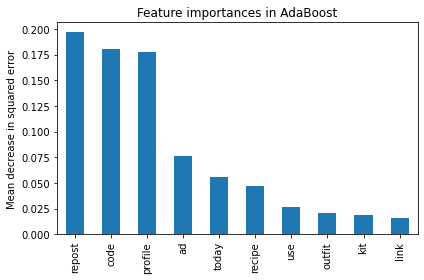

In [406]:
# The higher, the more important the feature. 
# The importance of a feature is computed as the (normalized) 
# total reduction of the criterion (squared error) brought by that feature. 
mse_decrease = ada_clf.feature_importances_[index][np.argsort(ada_clf.feature_importances_[index])[::-1]][:10]
forest_importances = pd.Series(mse_decrease, index=ada_clf.feature_names_in_[index][np.argsort(ada_clf.feature_importances_[index])[::-1]][:10])

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances in AdaBoost")
ax.set_ylabel("Mean decrease in squared error")
fig.tight_layout()


Feature importance is calculated in regression trees based on the total reduction of a criterion (squared error) brought by that feature. It does not imply that a particular feature is positively or negatively correlated with the dependent variable, but only the significance it has on producing meaningful results. It is also hard to infer anything statistically significant from the LASSO coefficients because of the high MAPE, but we can still learn about certain words by comparing the two models.  

Through the LASSO coefficients and AdaBoost feature importance, a couple words standout in particular such as "code", "link", "gifted", and "ad". These are all common terms that influencers use when they want to capture the attention of the audience by either selling them discounted products with their affiliate code or giveaway free items if the user satisfies certain conditions that are set by the influencer (usually includes liking and sharing the post which helps the influencer gain more traction). These tend to work well with the instagram audience which is why sponsors are always looking for new influencers to help them promote their products via this method. Even the word "profile" is often commonly used in captions to have the audience click on a specific link to purchase something, or look at a specific information in the bio such as their unique discount code. 

If we can compare the words between LASSO and AdaBoost, we see that the two overlapping words are "code", "use" and "outfit" which clearly shows the importance of discounts when promoting items for brands. These affiliate codes and links seem to draw people into whatever content the influencer is posting especially topics related to fashion, makeup, or dressing up. 

In [419]:
#look at some captions with the top words
codes = df1["caption"].loc[df1["caption"].str.contains(" code ") & ~df1["caption"].isnull()]
repost = df1["caption"].loc[df1["caption"].str.contains(" repost ") & ~df1["caption"].isnull()]
outfit = df1["caption"].loc[df1["caption"].str.contains(" outfit ") & ~df1["caption"].isnull()]

In [420]:
codes.iloc[0]

" 'incredibly excited to announce my partnership with @rocksbox this summer! start your summer off right and use promo code gracearagonxoxo to get 1 month free and enjoy your own beautiful, designer jewelry! #RBItGirl #Rocksbox'}}]"

In [421]:
codes.iloc[1]

' "If you are looking for baby food storage trays, you must check out the silicone baby food freezer trays by @kiddofeedo.\\n\\nHere are just some of the highlights: -------------------------------------\\nEach cube holds 2.6oz which is more than double than a regular ice cube tray.  That means that one full Freezer Tray can hold over 20oz of food! -------------------------------------\\nThe lid is also made of silicone with 8 little flaps that wrap around the edge of the tray. It being made of silicone means the lid is easy to clip-on and remove but the coolest part is that you can label the lid with food and dates with any ball point pen and it will easily wash off! ---------------------------------------------Most importantly, the trays are BPA, Phthalates and toxins free so it is super safe for baby.\\n\\nKiddo Feedo has created a promo code especially for @babyprepsundays followers which means you can now get 10% off when you purchase any color Kiddo Feedo Freezer Tray on Amazon.c

In [422]:
repost.iloc[0]

" 'I was running through the six with my woes.\\n\\nThe lovely ladies of Nike+NYC || repost from @nikenyc\\n\\n#NikeNYC #WeRunNYC #WeRunTO #BetterForIt #NikeToronto #NRC'}}]"

In [423]:
repost.iloc[1]

" 'Need 2 Akshay Kumar die hard fans for singh is bling special episode on my show the battle of the fan clubs to be shot on Wednesday in mumbai ...comment or dm me ..akki fans u May get a surprise if u get selected :) @livyourfame @akshaykumar @akshaykumarfb @akshaykumarfc @akshaykumarint @akshaykumarofficials @akshaykumarworld @akshaykumarteam @akshaykumar_fc repost \\n#akshaykumar #fans #akki #khiladi #kumar #singhisbling #sib #fame #livyourfame #fame #show #host #deepakkalra #bollywood #actor #anchor #superstar #famespecial #singh #bling #week'}}]"

In [424]:
outfit.iloc[0]

" 'Nice outfit for festival season created by me ! Crop top from @motelrocks , skirt from @topshop , shoes from @simplybeuk , bag from @chloe & sunglasses from @thehut_com #copyright #summer #look #fashion #skirt #topshop #sunglasses #gladiator #shoes #festivals #season #spring #hippie #style #loveit #byme'}}]"

In [425]:
outfit.iloc[1]

" 'Looking for the right outfit for sunny days and long summer nights? Check out why Maxi Skirts and Lace Up Sandals are my favorite summer pieces. ➡️ herpistolgo.com 📷 @dannylavega // @zerouv #herpistolgo #zerouv #sunnies #sunglasses #maxiskirt #croptop #laceup #sandals #laceupsandals #leathersandals #summer #outfit #summeroutfit #streetstyle #fashionblogger #fashionblogger_at #austrianblogger #blogger #igersvienna #bjorg #jewellery #thomassabo #fossil'}}]"

# Error Inspection

It seems like there are a lot of captions that don't contain the popular terms in our model, but still has lots of likes. We may need some other NLP models to help us in the future. 

In [411]:
#find the y predictions that have the largest errors
large_error = np.argsort(np.absolute(lasso_pred - Y_test))
original_data = Y_index[large_error]
jsons = pd.DataFrame(df1_sampled["json_id"][original_data])

#below are the captions of some of the highest prediction error
captions = jsons.merge(df1[["json_id", "caption"]], how = "inner")["caption"]
captions.iloc[0]

" 'So this may not have been the best idea🤔😳🤣\\n.\\nAaron and I recently found this adorable mini upholstered rocking chair (so similar to mommy’s @potterybarn rocking chair in GanMan’s room) for a screamin’ deal we just couldn’t pass up! We got it for Gannon thinking “this can be one of his birthday gifts,” but of course that turned into “eh let’s just give it to him now.” And well, he LOVES it.... for all the wrong reasons.\\n.\\nHe’s become a professional at using his chair to climb up onto the couch. And once he reaches his destination— he’s a tornado!🌪 Joyfully bouncing from couch cushion to couch cushion chewing on mom’s breast pump tubes and stealing the remote to push every. single. button. Dumping each pile of folded laundry in his path🧦👚👖👕 He’s pure destruction, and totally giddy about it.\\n.\\nSo of course I move his chair away from the couch in hopes to eliminate the problem. But did we eliminate the problem? More like traded that problem for another. Gannon decided it cou

In [412]:
captions.iloc[1]

" 'Look back at it 🍑 Watch my stories for a full cheek check in my @fabletics  leggings. \\nLink in bio to try them out for yourself for 2 for $24 ✌🏼#myfabletics #fableticsambassador'}}]"

In [413]:
captions.iloc[2]

" '♋️\\nLips/labial @jouercosmetics – Tawny Rose\\nHighlight/iluminador @beccacosmetics – opal\\nLashes/Pestanas @ardellbeauty 814 Fauxmink\\nEyeliner/Delineador - @rimmellondon  exagerate liner\\nBrows/Cejas @anastasiabeverlyhills brow definer medium brown\\nConcealer/corrector @maccosmetics prolongerwear NC25\\nBlush/rubor @bareminerals peachy keen\\nPalette/paleta @peronsacosmetics #identitypalette\\nFoundation/base @esteelauder #doublewear cashew\\n___________________________________________________\\n#maccosmetics #jouercosmetics #beccacosmetics #beccahighlighter #anastasiabeverlyhills #abh #anastasiabrows #ardellbeauty #bareminerals #personacosmetics #wakeupandmakeup #fashionblogger #makeup #motd #ootd #f21xme #fauxfur #bellamihair #bellami #gobare #makeupjunkie #teambellami #bellamihairproi #jouer #esteestories #esteelauder #esteelauderdoublewear #abhbrows'}}]"

In [414]:
captions.iloc[3]

" 'Finally got around to doing a massive overhaul on one of my family’s very favorite recipes.\\n. \\nThis Spicy Turkey Three-Bean Chili has a great blend of spices that is guaranteed to warm you up on a cold day like today.\\n. \\nI’ve revamped the post with tips for what types of beans to use, different types of meat that work well if you aren’t feeling like turkey, and our favorite tasty toppings. . \\nIf you don’t like your chili really fiery, no worries! I have tips for making a milder chili in there as well. . \\nBonus points if you love dipping cornbread in your chili like I do!\\n.\\nGet my recipe for Spicy Turkey Three-Bean Chili by clicking the link in my profile or heading to: https://bigflavorstinykitchen.com/spicy-turkey-three-bean-chili/\\n.\\n#chili #comfortfood #spicyfood #turkey #spicy\\n.\\n.\\n.\\n.\\n.\\n#beautifulcuisines #buzzfeast #cooking #devourpower #droolclub #eastcoastfoodie #eatingfortheinsta #f52grams #feedfeed @thefeedfeed #foodblogfeed #foodblogger #food

In [415]:
captions.iloc[4]

" 'Mood alpino 🐿🎀 @asos @zara .\\n.\\n.\\n.\\n.\\n.\\n.\\n.\\n.\\n.\\n.\\n.\\n.\\n.\\n#alpedisiusi #seiseralm #asos #zara #rayban #trentinoaltoadige #trentino #trentinodavivere #hotel'}}]"

# Conclusion

In summary, we have used NLP analysis of a huge dataset of captions as a feature in predicting popularity of influencers. Certain words increase the popularity of the post and provide more traction to the influencer while other contents could prove to be detrimental. 

For future work and given more resources for processing huge datasets, it will be insightful to also analyze the contents of comments elicited as a possible predictor (or indicator) of popularity. The TF-IDF scores on the captions have shown to be somewhat lackluster in terms of prediction strength due to the small number of text in each document. It seems that even though certain words are more powerful than others, it doesn't translate directly into more or less likes. However, it has helped explain some of the most prominent words used on Instagram. More NLP models should be considered in the future especially those that can provide semantic understanding of text.

Given the scarcity of Instagram-trained models for captions or comments, I also believe that it will be helpful to contribute to the field by creating our own instagram-trained model and compare to other existing Twitter or general purpose models, so that more businesses and social media users can benefit from our research.
